## Makes feature extraction with DYNO V2 autoencoder and finds the clustering with KNN having found the optimal K clusters

c:\Users\danil\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 500.10it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Balanced subset: 1000 images, embeddings shape (1000, 768)
Automatically detected optimal K: 8


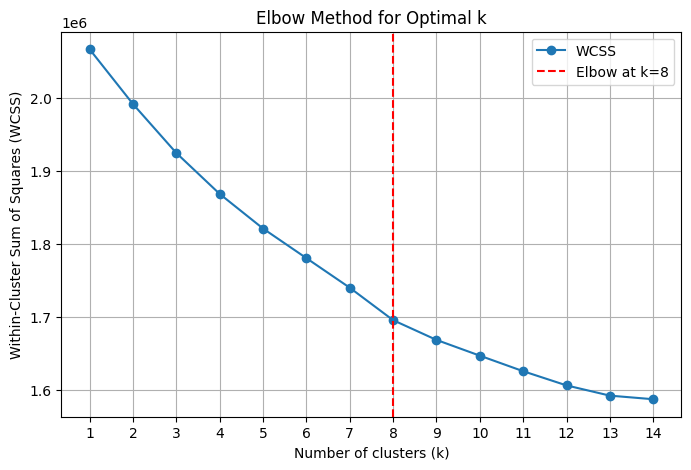

KMeans: 8 clusters, purity=0.766


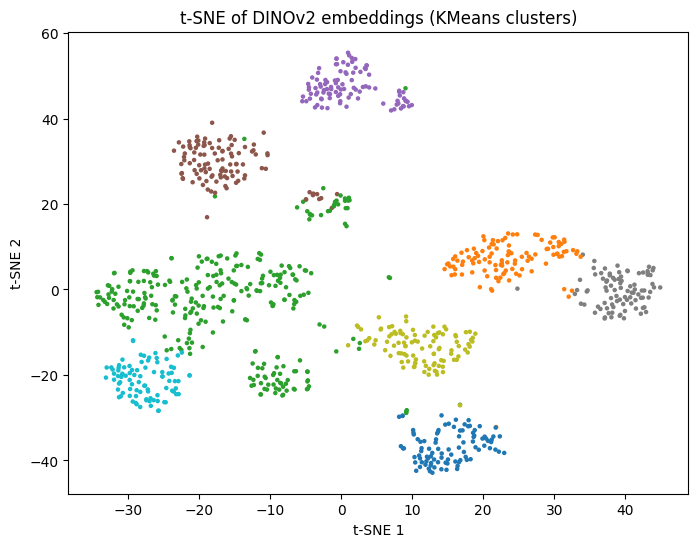

In [1]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, AutoModel
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import mode
from kneed import KneeLocator

# ==== 1. Load pretrained DINOv2 ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'facebook/dinov2-base'
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

# ==== 2. Balanced CIFAR-10 subset ====
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

full_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

N_PER_CLASS = 100
indices, class_counts = [], Counter()
for idx, (_, label) in enumerate(full_dataset):
    if class_counts[label] < N_PER_CLASS:
        indices.append(idx)
        class_counts[label] += 1
    if len(indices) == 10 * N_PER_CLASS:
        break

subset = torch.utils.data.Subset(full_dataset, indices)
dataloader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=False)

# ==== 3. Extract DINOv2 embeddings ====
all_embeddings, all_labels, original_images = [], [], []
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        outputs = model(pixel_values=images)
        cls_emb = outputs.last_hidden_state[:,0,:].cpu().numpy()
        all_embeddings.append(cls_emb)
        all_labels.append(labels.numpy())
        original_images.append(images.cpu())

all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
original_images = torch.cat(original_images, dim=0)

print(f"Balanced subset: {len(all_labels)} images, embeddings shape {all_embeddings.shape}")

# ==== 4. Helper functions ====
def cluster_purity(pred_labels, true_labels):
    clusters = set(pred_labels)
    total_correct = 0
    for c in clusters:
        if c == -1:
            continue
        mask = pred_labels == c
        if np.sum(mask) == 0:
            continue
        most_common = mode(true_labels[mask], keepdims=False).mode
        total_correct += np.sum(true_labels[mask] == most_common)
    return total_correct / len(true_labels)

# ==== 5. KMeans with Automatic Elbow Detection ====
wcss, K_range = [], range(1, 15)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(all_embeddings)
    wcss.append(km.inertia_)

knee = KneeLocator(K_range, wcss, curve='convex', direction='decreasing')
best_k = knee.knee
print(f"Automatically detected optimal K: {best_k}")

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', label='WCSS')
if best_k:
    plt.axvline(best_k, color='red', linestyle='--', label=f'Elbow at k={best_k}')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.show()
k_model = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(all_embeddings)
labels_kmeans = k_model.predict(all_embeddings)

purity = cluster_purity(labels_kmeans, all_labels)
print(f"KMeans: {best_k} clusters, purity={purity:.3f}")

# ==== 6. Visualization via t-SNE ====
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels_kmeans, s=5, cmap='tab10')
plt.title("t-SNE of DINOv2 embeddings (KMeans clusters)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

# ==== 7. Function to show images of a selected cluster ====
def show_cluster_images(images, labels, cluster_id, num_images=16):
    """Display sample images from a specific cluster."""
    idxs = np.where(labels == cluster_id)[0]
    if len(idxs) == 0:
        print(f"No images found for cluster {cluster_id}.")
        return
    idxs = np.random.choice(idxs, size=min(num_images, len(idxs)), replace=False)
    cols = int(np.sqrt(len(idxs)))
    rows = int(np.ceil(len(idxs)/cols))

    plt.figure(figsize=(cols*2, rows*2))
    for i, idx in enumerate(idxs):
        img = images[idx].permute(1,2,0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id} Samples")
    plt.show()

# ==== Example usage ====


#### Showing the found clusters

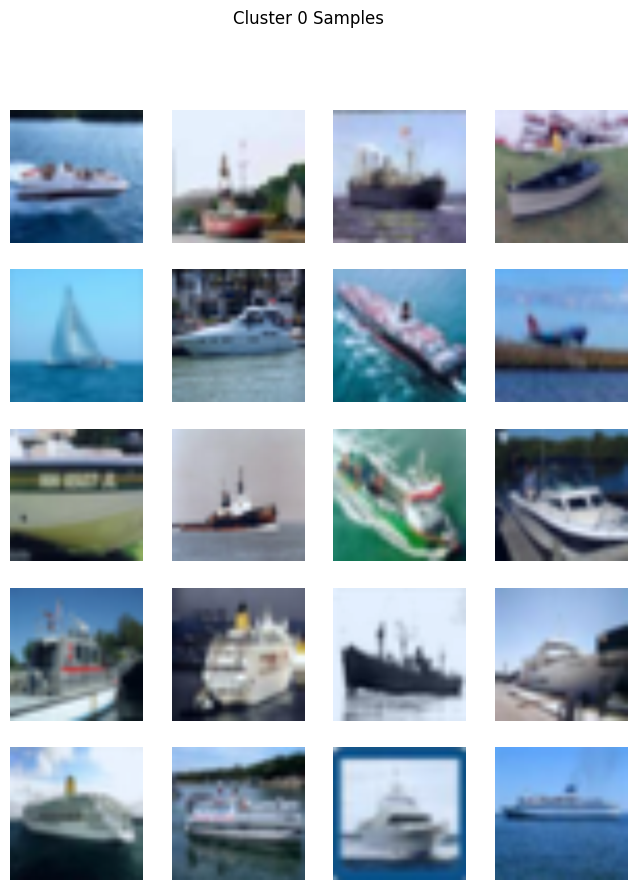

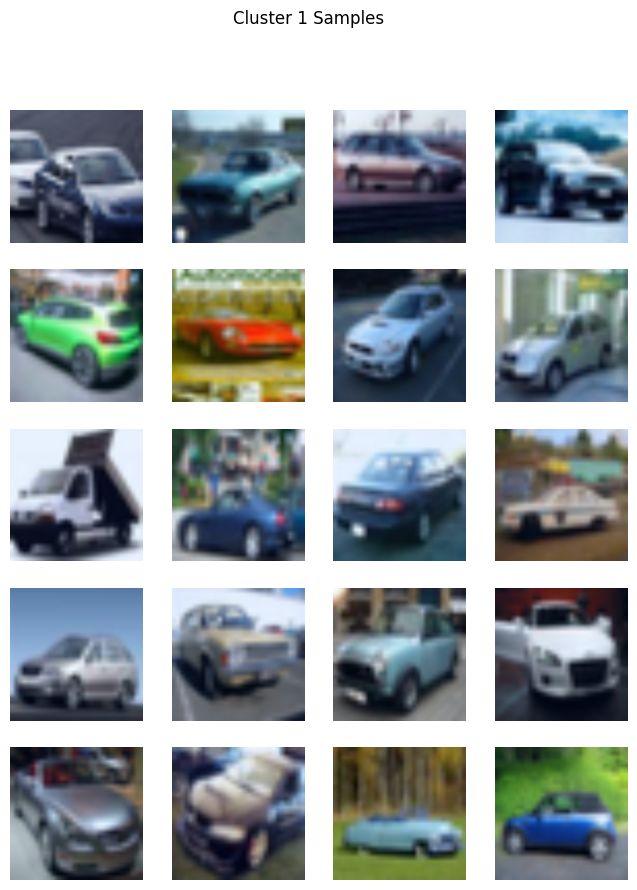

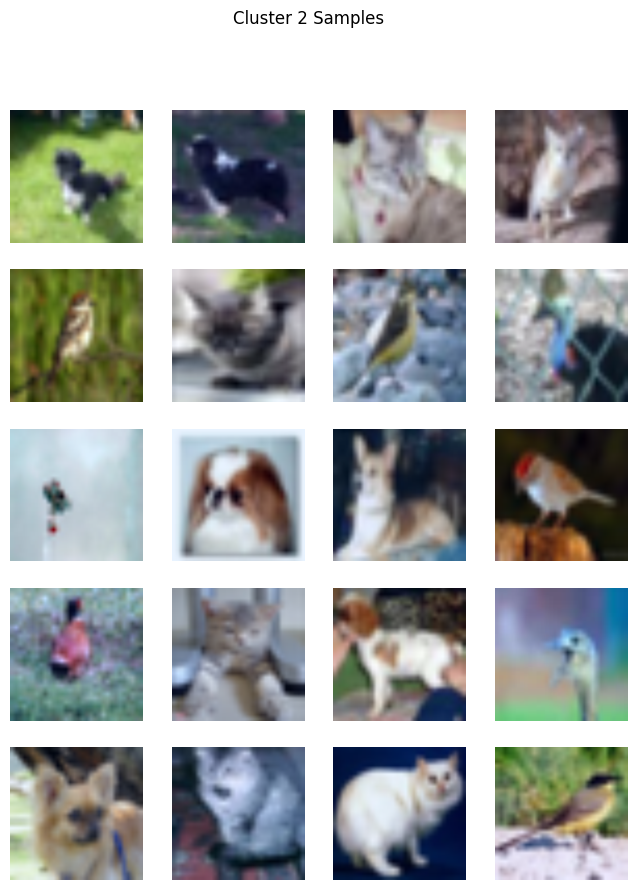

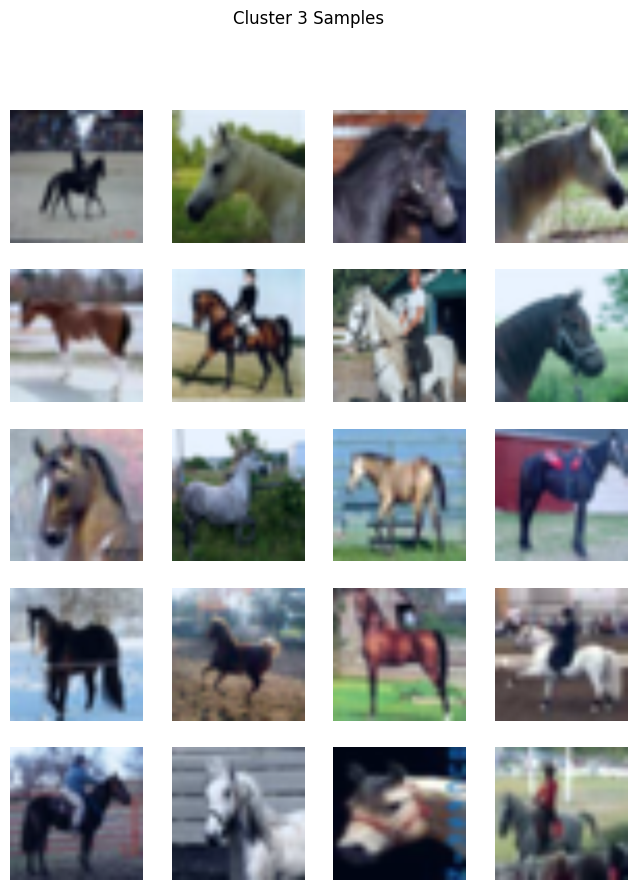

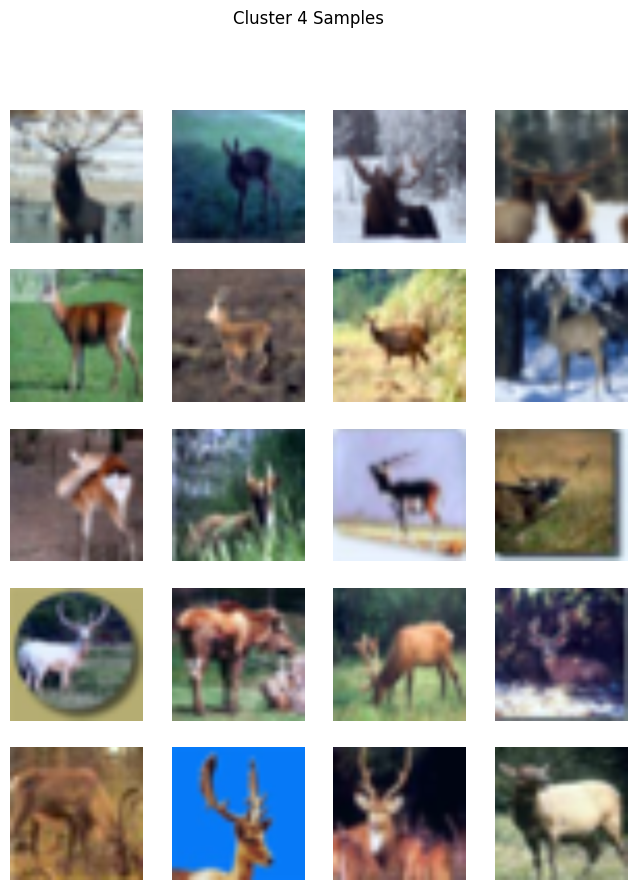

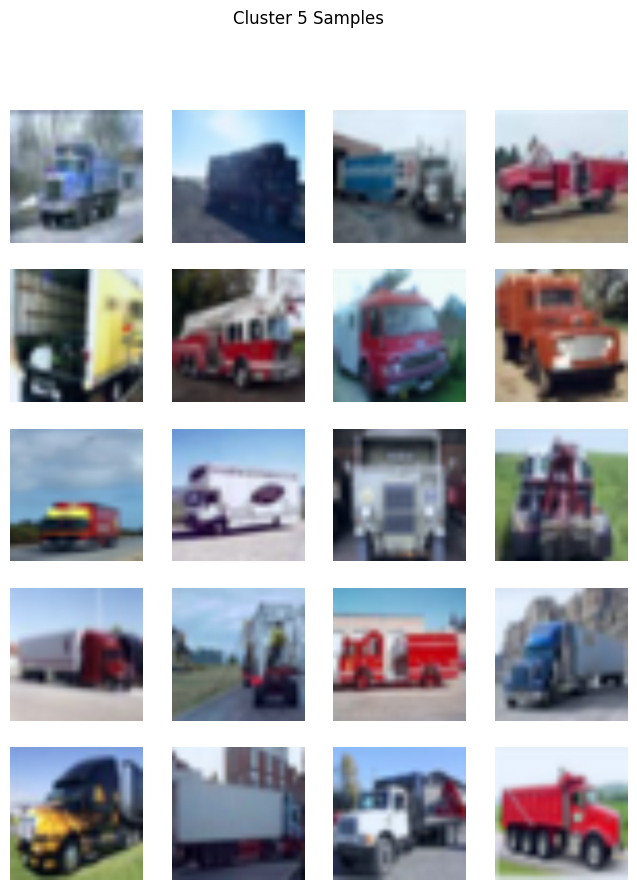

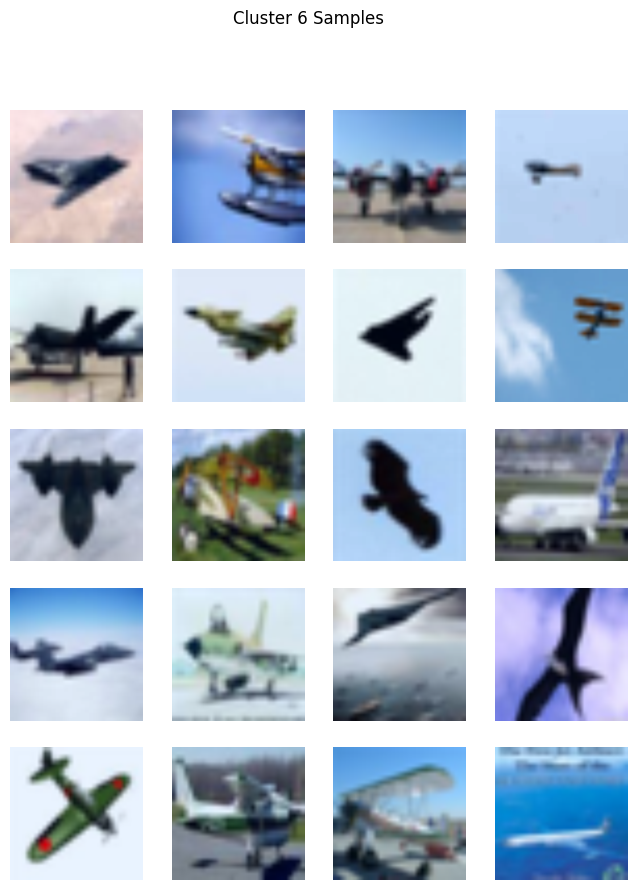

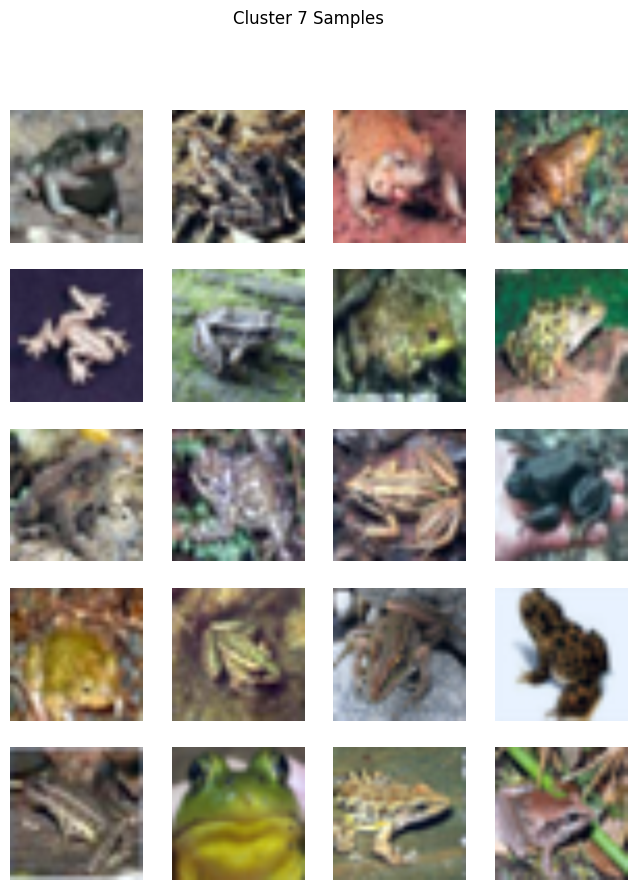

In [20]:
for i in range(0,best_k):
    show_cluster_images(original_images, labels_kmeans, cluster_id=i, num_images=20)

## We use CLIP to automatically label the found clusters

In [21]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
from collections import Counter

# Load CLIP model and processor
clip_model_name = "openai/clip-vit-base-patch16"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_model.eval()

# === 1. Get top-k images closest to each cluster centroid ===
def get_cluster_centroid_images(images, embeddings, cluster_labels, n_clusters, top_k=3):
    centroids = []
    for c in range(n_clusters):
        idxs = np.where(cluster_labels == c)[0]
        cluster_embs = embeddings[idxs]
        centroid = cluster_embs.mean(axis=0)
        dists = np.linalg.norm(cluster_embs - centroid, axis=1)
        top_idxs = idxs[np.argsort(dists)[:top_k]]
        centroids.append(top_idxs)
    return centroids

# === 2. Generate text labels using CLIP (without predefined candidates) ===
def clip_label_mode(images, indices, clip_model, clip_processor, device):
    """Assign a single-word label to a cluster using the mode of CLIP-generated captions."""
    captions = []
    for i in indices:
        img = images[i].permute(1,2,0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        pil_img = Image.fromarray((img*255).astype(np.uint8)).convert("RGB")

        # Use CLIP to encode the image
        inputs = clip_processor(images=pil_img, return_tensors="pt").to(device)
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)

        # Compare against a set of single-word candidates (you can define dynamic words if needed)
        # Here we use the top-k closest words from CLIP’s tokenizer vocabulary
        # For simplicity, let's use a set of common nouns as candidates
        candidate_labels = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog","mammal", "horse", "ship", "truck",'animals','others' ]
        text_inputs = clip_processor(text=candidate_labels, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            text_features = clip_model.get_text_features(**text_inputs)

        # Compute similarity
        image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features_norm = text_features / text_features.norm(dim=-1, keepdim=True)
        similarity = image_features_norm @ text_features_norm.T
        best_idx = similarity.argmax().item()
        captions.append(candidate_labels[best_idx])

    # Return the mode (most frequent) label among the top 3 images
    most_common_label = Counter(captions).most_common(1)[0][0]
    return most_common_label

# === 3. Apply to clusters ===
cluster_labels = labels_kmeans
n_clusters = len(set(cluster_labels))
centroid_indices = get_cluster_centroid_images(original_images, all_embeddings, cluster_labels, n_clusters, top_k=5)

cluster_label_names = []
for c, idxs in enumerate(centroid_indices):
    label = clip_label_mode(original_images, idxs, clip_model, clip_processor, device)
    cluster_label_names.append(label)
    print(f"Cluster {c}: {label}")


Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


Cluster 0: ship
Cluster 1: automobile
Cluster 2: dog
Cluster 3: horse
Cluster 4: deer
Cluster 5: truck
Cluster 6: airplane
Cluster 7: frog


### Now we create the inference flow by labelling a random image of the CIFAR10 dataset

In [22]:
def label_new_image(image, processor, model, cluster_label_names, device, kmeans_model=k_model):
    """
    Label a new image by assigning it to the nearest cluster and returning the cluster's name.

    Args:
        image: PIL.Image or torch.Tensor
        processor: AutoImageProcessor used for embeddings
        model: DINOv2 model
        kmeans_model: trained KMeans model
        cluster_label_names: list of names for each cluster (cluster ID → name)
        device: torch device

    Returns:
        cluster_name: str, name of the assigned cluster
        cluster_id: int, ID of the assigned cluster
        distance: float, distance to the cluster centroid
    """
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
    ])
    
    if not isinstance(image, torch.Tensor):
        image = transform(image).unsqueeze(0)
    else:
        image = image.unsqueeze(0)
    
    image = image.to(device)

    with torch.no_grad():
        outputs = model(pixel_values=image)
        emb = outputs.last_hidden_state[:,0,:].cpu().numpy()  # shape (1, embedding_dim)

    centroids = kmeans_model.cluster_centers_
    distances = np.linalg.norm(centroids - emb, axis=1)
    cluster_id = np.argmin(distances)
    cluster_name = cluster_label_names[cluster_id]
    
    return cluster_name


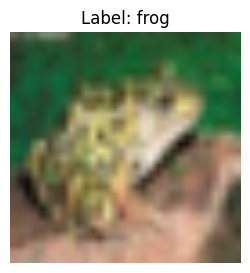

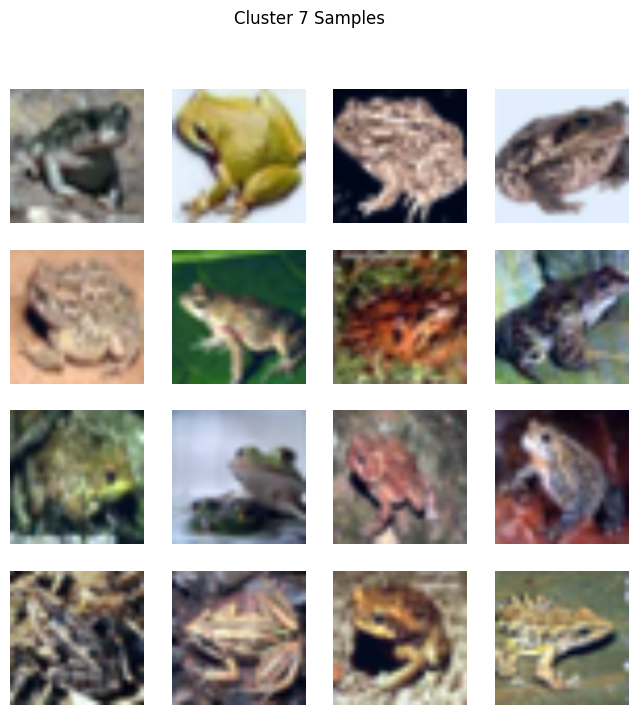

In [34]:
def unnormalize(img_tensor, mean, std):
    """
    img_tensor: torch tensor of shape (C,H,W) normalized
    mean, std: lists of length C
    """
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)  # unnormalize
    return img_tensor

# Pick a random image
query_idx = np.random.randint(len(original_images))
query_image = original_images[query_idx].clone()  # clone to avoid modifying original

# Unnormalize
query_image = unnormalize(query_image, processor.image_mean, processor.image_std)

# Convert to PIL
img_to_show = transforms.ToPILImage()(query_image)

# Assign cluster
cluster_name = label_new_image(
    img_to_show,
    processor,
    model,
    cluster_label_names=cluster_label_names,
    device=device
)

# Find assigned cluster id
assigned_cluster_id = cluster_label_names.index(cluster_name)

# Display the query image and label
plt.figure(figsize=(3,3))
plt.imshow(img_to_show)
plt.title(f"Label: {cluster_name}")
plt.axis('off')
plt.show()

# Show a sample of images from the assigned cluster
show_cluster_images(original_images, labels_kmeans, cluster_id=assigned_cluster_id, num_images=16)



### Now we evaluate the accuracy for the different labels the CIFAR10 dataset originally has

In [35]:
import numpy as np
from collections import defaultdict

# CIFAR-10 class names
cifar10_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

# Assume predicted_labels is already computed in the notebook (length 1000)
# Get true labels for the evaluation subset
true_labels = []
for idx in range(0,len(original_images)):
    _, label = subset[idx]
    true_labels.append(label)
true_label_names = [cifar10_names[l] for l in true_labels]

# Global accuracy
correct = sum(pred == true for pred, true in zip(predicted_labels, true_label_names))
accuracy = correct / len(true_label_names)
print(f"\nOverall labelling accuracy: {accuracy:.3f}")

# Per-class accuracy
class_correct = defaultdict(int)
class_total = defaultdict(int)
for pred, true in zip(predicted_labels, true_label_names):
    class_total[true] += 1
    if pred == true:
        class_correct[true] += 1

print("\nPer-class accuracy:")
for cls in cifar10_names:
    acc = class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0.0
    print(f"{cls:>10s}: {acc:.3f} ({class_correct[cls]}/{class_total[cls]})")


Overall labelling accuracy: 0.766

Per-class accuracy:
  airplane: 0.960 (96/100)
automobile: 1.000 (100/100)
      bird: 0.000 (0/100)
       cat: 0.000 (0/100)
      deer: 0.980 (98/100)
       dog: 1.000 (100/100)
      frog: 0.890 (89/100)
     horse: 0.990 (99/100)
      ship: 0.940 (94/100)
     truck: 0.900 (90/100)


This notebook shown is the experimentation and not the final algorithm, it has been shown instead of said scripts due to the advantages it gives for visalization and understanding of the code.